In [1]:

pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Gerekli kütüphanelerin yüklenmesi

import os
import random
import numpy as np
import sklearn
import cv2 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


import visualkeras
from visualkeras import layered_view
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

In [177]:
print(cv2.__version__)

4.10.0


In [178]:
print(sklearn.__version__)

1.5.0


In [5]:
seed_constant = 18
random.seed(seed_constant)

In [3]:
#total_pic_names  #değişkende saklı tüm resimlerin isimlerini alt alta sırala.
#bu şekilde --- 23_1_2_20170116173110409.jpg.chip.jpg
#print(total_pic_names)  #yan yana sırala

#verisetimizin dizin yolunu gösterelim
pic_dir = r'C:\Users\MeNoktaKemal\Desktop\proje1\dataset250'
total_pic_names = os.listdir(pic_dir)
len(total_pic_names)

250

In [9]:
#total_pic_nameste saklı görüntülerin içinden rastgele 6 tanesinin indeksini göster. 
''' 
random.sample içine tanımladığımız "range(n)" ifadesi 0'dan n-1'e kadar olan sayıları içeren bir dizini temsil eder. 
burada n dediğimiz kısım "len(total_pic_names)" olarak belirlendi.
yani 0'dan total_pic_names'in eleman sayısına kadar (24109) bir sayı dizisi oluşturur.
yani bir manada artık, range(len(total_pic_names) sayı dizisi verisetimiz görsellerinin indislerini barındırıyor diyebiliriz.
random.sample işlevi, bu indis dizisinden rastgele 6 tanesini seçer ve random_select değişkenine atar.

''' 
random_select = random.sample(range(len(total_pic_names)), 6)
print(random_select)

[50, 243, 125, 160, 126, 46]


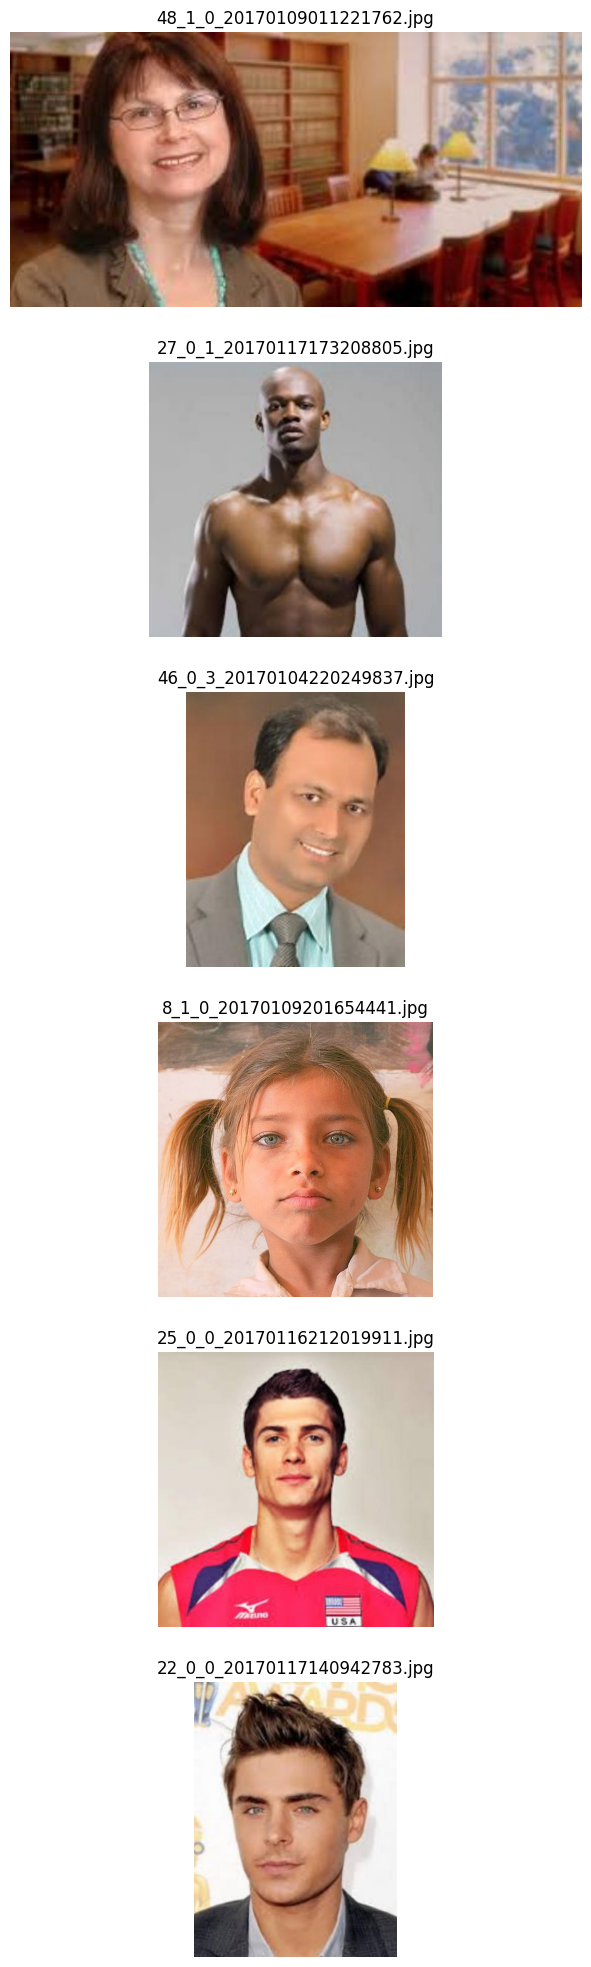

In [10]:
# Veri setimiz içerisinden dosya isimleriyle birlikte 6 rastgele görüntüyü görselleştirelim.
'''
random_index değişkeni, random_select listesindeki elemanların kendilerini temsil eder. 
yani random_select = [15739, 18800, 3316, 23088, 6594, 19280] ise, 

ilk döngüde; sayaç 1, random_index '15739' olur. 
total_pic_namesteki 15739. sıradaki dosya adı alınır ve pic_name değişkenine atanır. 
ikinci döngüde; sayaç 2, random_index '18800' olur. 18800. sıradaki dosya adı alınır ve pic_name'e atanır.
pic_name değişkeni her döngüde rastgele seçilmiş random_select dizinindeki 6 görüntünün adını sırayla alır.

'''

# Görüntüleri görelleştirme
plt.figure(figsize = (25,25))
random_select = random.sample(range(len(total_pic_names)), 6)

for counter, random_index in enumerate(random_select, 1):
    pic_name = total_pic_names[random_index]

    # Dosya yolu oluşturma, resmi okuma ve RGB formatına çevirme
    pic_path = os.path.join(pic_dir, pic_name)
    pic_bgr = cv2.imread(pic_path)
    pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)

    # Görüntüyü, adıyla birlikte gösterme
    plt.subplot(6, 1, counter)
    plt.imshow(pic_rgb)
    plt.title(pic_name)
    plt.axis('off')

plt.show()

    

In [190]:
# Veri setini ön işlemeye başlayalım (Preprocessing)

# Görüntü dosyalarını yeniden boyutlandırıp, normalize edecek bir 'image_preprocessing' işlevi tanımlayalım. 

pic_height = 224
pic_width = 224

def image_processing(pic_path):
    pic = cv2.imread(pic_path)
    resized_pic = cv2.resize(pic, (pic_height, pic_width))
    normalized_pic = resized_pic / 255
    return normalized_pic


# Etiketleri çıkarmak için işlev oluşturalım

# Yaş etiketi çıkarmak için fonksiyon tanımlayalım.
def age_label_extraction(pic_name):
    age = int(pic_name.split("_")[0])
    return age  #Yaş sınıfı indeksini doğrudan yaş olarak belirledik.'''

# Cinsiyet etiketi çıkarmak için fonksiyon tanımlayalım.
def gender_label_extraction(pic_name):
    try:
        gender = int(pic_name.split("_")[1])
        if gender == 0 or gender == 1:
            return gender
        else:
            return None  # veya geçersiz bir durum için uygun bir işlem yapabilirsiniz
    except (IndexError, ValueError) as e:
        print(f"Hata: {e}. Pic name: {pic_name}")
        return None

# görüntülerin özelliklerini ve etiketlerini oluşturalım.
def create_dataset():

    features = [] # Özellikler 
    age_labels = []  # yaş etiketleri 
    gender_labels = [] # cinsiyet etiketleri

    for pic_name in total_pic_names:
        
            
        pic_path = os.path.join(pic_dir, pic_name)
        preprocessed_pic = image_processing(pic_path) #preprocessed_pic = normalized_pic 
        age_index = age_label_extraction(pic_name)
        gender_index = gender_label_extraction(pic_name)
        
        features.append(preprocessed_pic)
        age_labels.append(age_index)
        gender_labels.append(gender_index)


    features = np.array(features)
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)

    return features, age_labels, gender_labels

# bu aşamada gerekirse """ONE HOT ENCODING"""" uygulanacak. şimdilik atlayalım.



In [124]:
# Verileri eğitim ve test setine bölelim

# Veri setimizi oluşturalım.
features, age_labels, gender_labels = create_dataset()

# Özellikleri ve yaş etiketlerini ayıralım
features_train, features_test, age_labels_train, age_labels_test = train_test_split(features, age_labels, test_size=0.1,
 
                                                                                    shuffle=True, random_state=seed_constant)
# Özellikleri ve cinsiyet etiketlerini ayıralım
features_train, features_test, gender_labels_train, gender_labels_test = train_test_split(features, gender_labels, test_size=0.1,
                                                                                          shuffle=True, random_state=seed_constant)


In [125]:
# VGG16 modelimizi yükleyelim vw yapılandıralım. son katmanı almadık.
input_shape = (224, 224, 3)
vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# Zaten eğitilmiş olan VGG katmanlarını donduralım
for layer in vgg.layers:
    layer.trainable = False

# Düzleştirme katmanı ekleyelim
x = Flatten()(vgg.output)

# Yoğun bağlı katmanlar ekleyerek, relu aktivasyonu ve L2 düzenlemesi uygulayalım
# Ayrıca, %50 dropout kullanarak ağın genelleştirme yeteneğini artıralım ve overfitting azaltalım.
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

# Yaş tahmini için regresyon katmanı oluşturalım
age_prediction = Dense(1, activation='linear', name='age_prediction')(x)

# Cinsiyet tespiti için sınıflandırma katmanı oluşturalım
gender_prediction = Dense(1, activation='sigmoid', name='gender_prediction')(x)

# Modelimizi tanımlayalım
model = Model(inputs=vgg.input, outputs=[age_prediction, gender_prediction])

# Modelimizin özetini yazdıralım
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 224, 224, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 224, 224, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 112, 112, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 112, 112, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 112, 112, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 56, 56, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 56, 56, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 28, 28, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 28, 28, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 14, 14, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 40,060,458 (152.82 MB)

 Trainable params: 25,345,770 (96.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

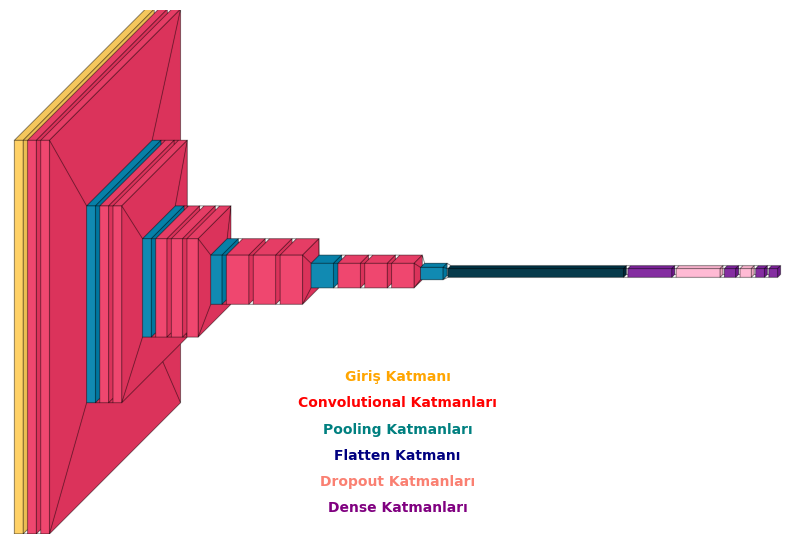

In [126]:
# Modelimizi görselleştirelim

visualkeras.layered_view(model, to_file='model.png')
visualmodel = plt.imread('model.png')
plt.figure(figsize=(10, 10))
plt.imshow(visualmodel)
plt.axis('off')

plt.text(0.5, 0.05, 'Dense Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='purple', fontweight='bold')
plt.text(0.5, 0.15, 'Flatten Katmanı', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='navy', fontweight='bold')
plt.text(0.5, 0.10, 'Dropout Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='salmon', fontweight='bold')
plt.text(0.5, 0.20, 'Pooling Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='teal', fontweight='bold')
plt.text(0.5, 0.25, 'Convolutional Katmanları', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red', fontweight='bold')
plt.text(0.5, 0.30, 'Giriş Katmanı', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='orange', fontweight='bold')

plt.show()


In [127]:
'''# EarlyStopping oluşturalım
early_stopper = EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

# CheckPoint oluşturalım
filepath = "BestWeights_trial.keras"
weight_saver = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)'''

# Yeni early ve checkpoint deneme
# EarlyStopping oluşturalım
early_stopper = EarlyStopping(
    monitor='val_age_prediction_mae', 
    patience=6, 
    mode='min', 
    restore_best_weights=True)

# CheckPoint oluşturalım
filepath = "BestWeights_trial.keras"
weight_saver = ModelCheckpoint(filepath, 
                               monitor='val_gender_prediction_accuracy',  
                               verbose=1, 
                               mode='max',  
                               save_best_only=True)


# callbacks
callbacks_list = [early_stopper, weight_saver]

# Modeli derleyelim, modelimiz birden fazla çıktı ürettiği için (age ve gender) loss ve metrics dictionary(sözlük) olarak belirtilmiştir. 
model.compile( 
    optimizer=Adam(),
    loss={'age_prediction': 'mean_squared_error', 
          'gender_prediction': 'binary_crossentropy'},
    metrics={'age_prediction': 'mae', 
             'gender_prediction': 'accuracy'}) 
             
# Modelimizi eğitelim
history = model.fit(
    features_train, {'age_prediction': age_labels_train, 'gender_prediction': gender_labels_train},
    epochs = 20, 
    batch_size = 8,
    validation_split= 0.1,
    callbacks = callbacks_list)
    
    

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - age_prediction_mae: 35.0885 - gender_prediction_accuracy: 0.5842 - loss: 1847.8528
Epoch 1: val_gender_prediction_accuracy improved from -inf to 0.43478, saving model to BestWeights_trial.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 748ms/step - age_prediction_mae: 34.9632 - gender_prediction_accuracy: 0.5809 - loss: 1834.0182 - val_age_prediction_mae: 21.9893 - val_gender_prediction_accuracy: 0.4348 - val_loss: 681.6924
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - age_prediction_mae: 24.3755 - gender_prediction_accuracy: 0.5284 - loss: 925.0255
Epoch 2: val_gender_prediction_accuracy improved from 0.43478 to 0.56522, saving model to BestWeights_trial.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 740ms/step - age_prediction_mae: 24.3971 - gender_prediction_accuracy: 0.5271 - loss: 925.3005 - val_age_prediction_mae: 19.4454 - val_gender_prediction_accuracy: 0.5652 - val_loss: 549.2201
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - age

In [128]:
# En iyi doğrulama doğruluğuna sahip modelin ağırlıklarını yükleyelim
model.load_weights("BestWeights_trial.keras")

In [129]:
# Modeli test verisi üzerinde değerlendirelim

model_evaluation_history = model.evaluate(features_test, {'age_prediction': age_labels_test, 'gender_prediction': gender_labels_test})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - age_prediction_mae: 23.5517 - gender_prediction_accuracy: 0.4800 - loss: 731.8306


In [130]:
# Modelimizi kaydedelim
model.save("best_val_acc_model.keras")

In [131]:
print(history.history.keys())


dict_keys(['age_prediction_mae', 'gender_prediction_accuracy', 'loss', 'val_age_prediction_mae', 'val_gender_prediction_accuracy', 'val_loss'])


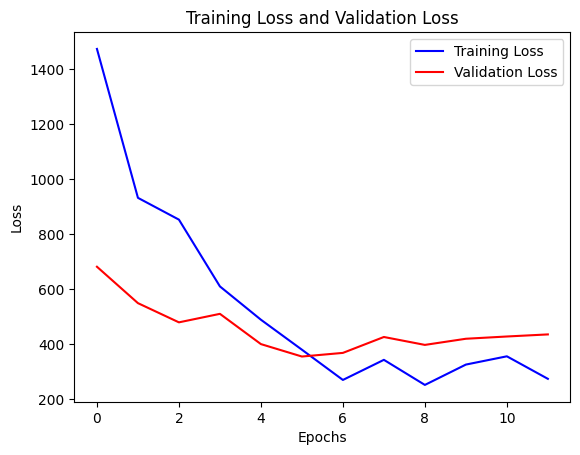

In [132]:
# Eğitim ve Doğrulama Kaybı Grafiği Oluşturalım (modelin genel performansını inceleyelim)

epochs = range(len(history.history['loss']))

plt.plot(epochs, history.history['loss'], 'blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'red', label='Validation Loss')

plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


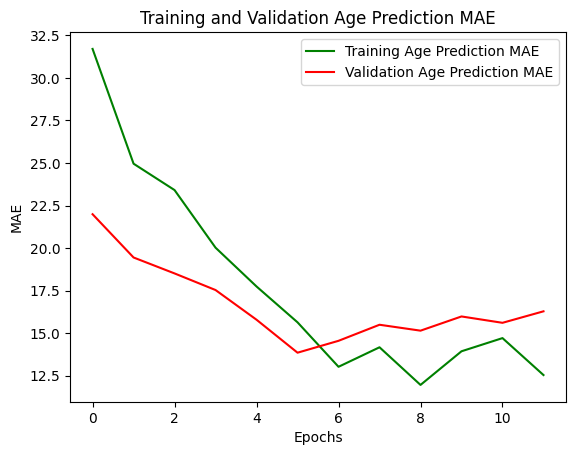

In [133]:
# Yaş Tahmin MAE Grafiği Oluşturalım (Yaş tahmini doğruluğu grafiği) - düşük olmalı

epochs = range(len(history.history['age_prediction_mae']))

plt.plot(epochs, history.history['age_prediction_mae'], 'green', label='Training Age Prediction MAE')
plt.plot(epochs, history.history['val_age_prediction_mae'], 'red', label='Validation Age Prediction MAE')

plt.title('Training and Validation Age Prediction MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

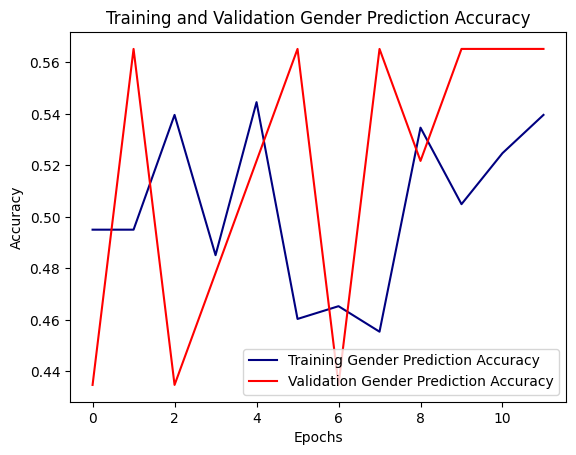

In [134]:
# Cinsiyet Tahmini Doğruluğu Grafiği OLuşturalım

epochs = range(len(history.history["gender_prediction_accuracy"]))

plt.plot(epochs, history.history["gender_prediction_accuracy"], 'navy', label="Training Gender Prediction Accuracy")
plt.plot(epochs, history.history["val_gender_prediction_accuracy"], 'red', label="Validation Gender Prediction Accuracy")

plt.title("Training and Validation Gender Prediction Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [220]:
# Modelimizi yeni Görüntü verileriyle test edelim


def detect_age_gender(pic_path):
    try:
        # Görüntüyü ön işleme tabi tutalım
        picture = image_processing(pic_path)
        print("Picture shape:", picture.shape)
        print("Picture dtype:", picture.dtype)
        
        reshaped_pic = np.reshape(picture, (1, pic_height, pic_width, 3))
        normalized_picture = reshaped_pic / 255

        # Modelden tahminler alalım
        predictions = model.predict(normalized_picture) 

        age_prediction = predictions[0][0] 
        gender_prediction = predictions[1][0] 

        '''
        model.predict fonksiyonu 2 tahmin döndürecektir; yaş ve cinsiyet.
        
        age_prediction için açıklama:
        1. predictions[0]: Modelin birinci çıkışını temsil eder. Bu çıkış, yaş tahminini yapar.
        2. predictions[0][0]: predictions[0]'ın ilk elemanıdır ve bu, yaş tahmininin doğrudan değeridir. 
           Model, yaş tahminini 'lineer aktivasyon fonksiyonu' kullanarak doğrudan bir sayısal değer olarak döndürür. 
           Bu değer doğrudan 'age_prediction' değişkeninde saklanır.
        
        gender_prediction için açıklama:
        1. predictions[1]: Modelin ikinci çıkışını temsil eder. Bu çıkış, cinsiyet tahminini yapar.
        2. predictions[1][0]: predictions[1]'in ilk elemanıdır ve bu, cinsiyet tahmininin olasılık değeridir. 
           Model, cinsiyet tahminini 'sigmoid aktivasyon fonksiyonu' kullanarak [0, 1] aralığında bir olasılık değeri olarak döndürür. 
           Bu değer, '0.5' eşik değerinden büyükse "Erkek", küçükse "Kadın" olarak sınıflandırılır ve 'gender' değişkenine atanır.
        '''

        # Cinsiyet tahminini belirleyelim
        if gender_prediction > 0.5:
            gender = "Erkek"
        else:
            gender = "Kadın"

        return age_prediction, gender
    
    except Exception as e:
        print(f"Hata: {e}")
        return None, None



Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


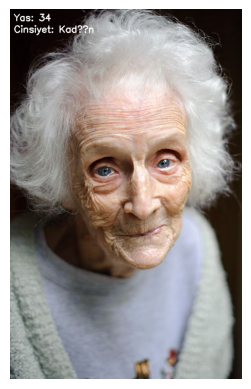

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


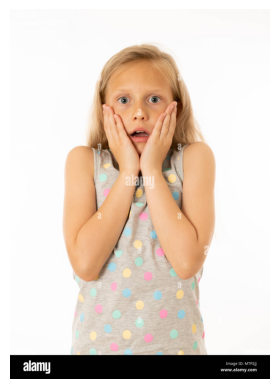

Hata: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Görüntü okunamadı: C:\Users\MeNoktaKemal\Desktop\proje1\newdataset\Ekran görüntüsü 2024-07-05 035155.jpg
Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


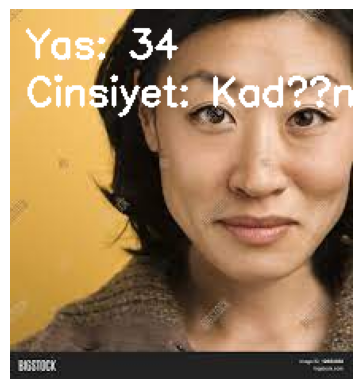

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


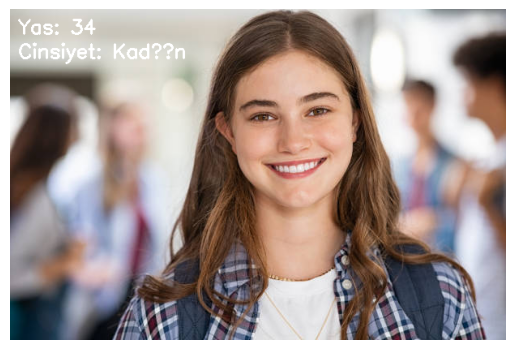

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


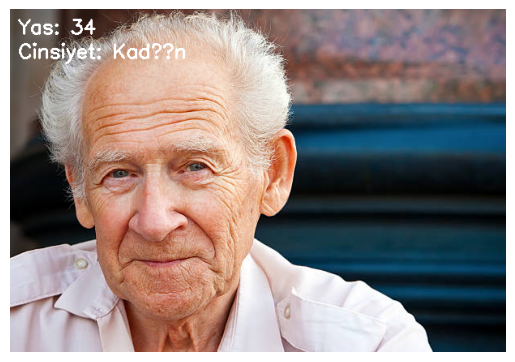

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


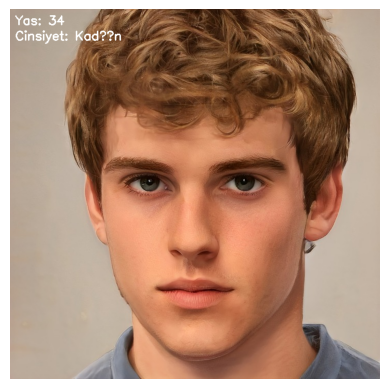

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


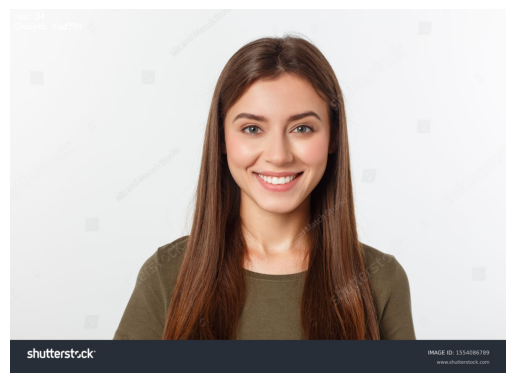

Picture shape: (224, 224, 3)
Picture dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


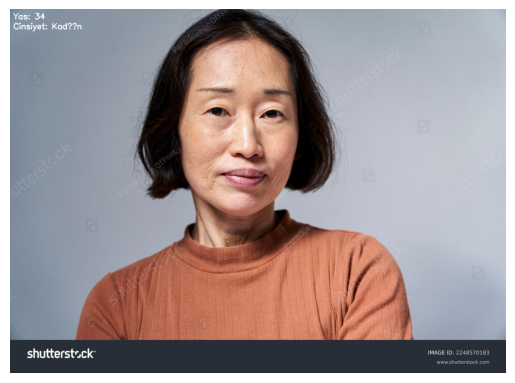

In [235]:
# Yeni veri seti yolumuzu belirleyelim

newset_dir = r'C:\Users\MeNoktaKemal\Desktop\proje1\newdataset'
newset_pic_names = os.listdir(newset_dir)

for counter, newset_pic_name in enumerate(newset_pic_names):
    # Seçilen görüntünün dosya yolu
    newpic_path = os.path.join(newset_dir, newset_pic_name)

    # Tahminleme yapalım
    predicted_age, predicted_gender = detect_age_gender(newpic_path)

    # Görüntüyü okuyalım
    newpic_bgr = cv2.imread(newpic_path)
    if newpic_bgr is None:
        print(f"Görüntü okunamadı: {newpic_path}")
    else:
        # Görüntü başarıyla okundu, şimdi resize işlemi yapabilirsiniz
        newpic_rgb = cv2.cvtColor(newpic_bgr, cv2.COLOR_BGR2RGB)

        # Tahmin edilen yaş ve cinsiyeti görüntünün üstüne yazalım
        cv2.putText(newpic_rgb, f"Yas: {int(predicted_age[0])}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(newpic_rgb, f"Cinsiyet: {predicted_gender}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # Seçilen görüntüyü gösterelim
        plt.imshow(newpic_rgb)
        plt.axis('off')
        plt.show()